<a href="https://colab.research.google.com/github/MutyaAnissa/Files/blob/main/XGBoost%2C_SMOTE_Tomek%2C_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.0 MB/s eta 0:00:00


[I 2025-09-24 02:42:36,174] A new study created in memory with name: no-name-1c472839-d467-4873-b4b9-001f9ddbf4e2
[I 2025-09-24 02:42:36,797] Trial 0 finished with value: 0.9895459976105138 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.16163380548381578, 'subsample': 0.8518370987725175, 'colsample_bytree': 0.7326088786631125, 'gamma': 0.8401983323140095, 'reg_alpha': 0.9665420935082383, 'reg_lambda': 1.2098529974274483, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.9895459976105138.
[I 2025-09-24 02:42:37,650] Trial 1 finished with value: 0.9662485065710872 and parameters: {'n_estimators': 229, 'max_depth': 10, 'learning_rate': 0.13764726363562954, 'subsample': 0.7844795916037332, 'colsample_bytree': 0.5856399503941674, 'gamma': 0.24774020879550618, 'reg_alpha': 0.0793801480271018, 'reg_lambda': 3.002240834648233, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.9895459976105138.
[I 2025-09-24 02:42:38,180] Trial 2 finished with value: 0.9835722

Best Trial:
{'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.2980100240564405, 'subsample': 0.9835331829857946, 'colsample_bytree': 0.516163599393163, 'gamma': 0.45762774583130506, 'reg_alpha': 0.9794185635768204, 'reg_lambda': 1.1464410070178364, 'scale_pos_weight': 10}
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.64      0.78       837
           1       0.73      1.00      0.84       837

    accuracy                           0.82      1674
   macro avg       0.86      0.82      0.81      1674
weighted avg       0.86      0.82      0.81      1674


Confusion Matrix:
[[533 304]
 [  3 834]]

ROC AUC: 0.9495645682295392


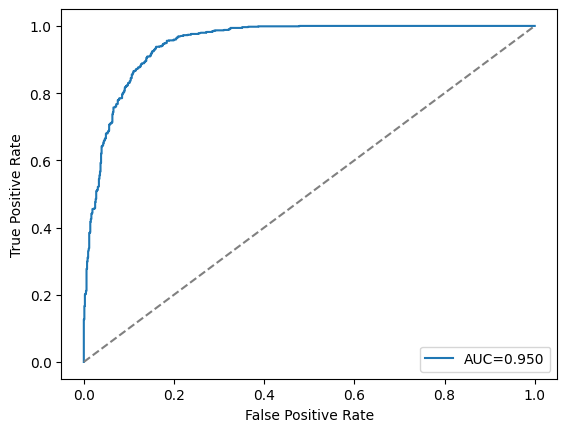

In [ ]:
# === Instalasi library ===
!pip install optuna imbalanced-learn xgboost

# === Import Library ===
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import optuna

# === Contoh load dataset ===
df = pd.read_csv("stroke dataset.csv")

# =========================
# 1. Missing Value Imputation (BMI dengan MICE)
# =========================
imputer = IterativeImputer(max_iter=10, random_state=42)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# =========================
# 2. Outlier Handling
# =========================
from scipy import stats
# Z-Score untuk BMI
z = np.abs(stats.zscore(df['bmi']))
df = df[(z < 3)]

# IQR untuk avg_glucose_level
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['avg_glucose_level'] >= (Q1 - 1.5 * IQR)) &
        (df['avg_glucose_level'] <= (Q3 + 1.5 * IQR))]

# =========================
# 3. Feature Engineering
# =========================
X = df.drop(columns=['stroke', 'id']) # Drop kolom id
y = df['stroke']

categorical = ['gender', 'smoking_status']
numerical = ['age', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', StandardScaler(), numerical)],
    remainder='drop'
)

X = preprocessor.fit_transform(X)

# Seleksi fitur (contoh pilih 8 terbaik)
selector = SelectKBest(score_func=f_classif, k=8)
X = selector.fit_transform(X, y)

# =========================
# 4. Balancing Dataset (SMOTE-Tomek)
# =========================
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X, y)

# =========================
# 5. Split Data
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# =========================
# 6. Optimasi Hyperparameter dengan Optuna
# =========================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 10),
        "eval_metric": "logloss",
        "random_state": 42
    }

    xgb = XGBClassifier(**params)
    scores = cross_val_score(
        xgb, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="recall"
    )
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Trial:")
print(study.best_trial.params)

# =========================
# 7. Training model terbaik
# =========================
best_params = study.best_trial.params
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# =========================
# 8. Evaluasi
# =========================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
